### Hopfield Energy Demonstration for Pattern Retrieval Task

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2

from hopfield_layers.modules import Hopfield

In [2]:
def load_simpson_faces(path, start, end):
    imgs = []
    simpson_files = os.listdir(path)
    
    for img in simpson_files[start:end]:
        image = cv2.imread(path+img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.array(image)/255.0
        imgs.append(image)
    
    return torch.from_numpy(np.array(imgs)).float()

In [3]:
hopfield = Hopfield(
    scaling=1.0,

    # do not project layer input
    state_pattern_as_static=True,
    stored_pattern_as_static=True,
    pattern_projection_as_static=True,

    # do not pre-process layer input
    normalize_stored_pattern=False,
    normalize_stored_pattern_affine=False,
    normalize_state_pattern=False,
    normalize_state_pattern_affine=False,
    normalize_pattern_projection=False,
    normalize_pattern_projection_affine=False,

    # do not post-process layer output
    disable_out_projection=True)

loading simpsons_faces dataset from [kaggle](https://www.kaggle.com/kostastokis/simpsons-faces):

In [37]:
imgs = load_simpson_faces('simpsons_faces/', 0, 24)

In [38]:
Y = imgs.clone().reshape(24,-1).unsqueeze(0) # stored patterns 

R = imgs[0].clone()
R += torch.rand(R.shape)*0.15 # inject noise into state pattern
R.clamp_(0, 1)
R = R.reshape(1,-1).unsqueeze(0)

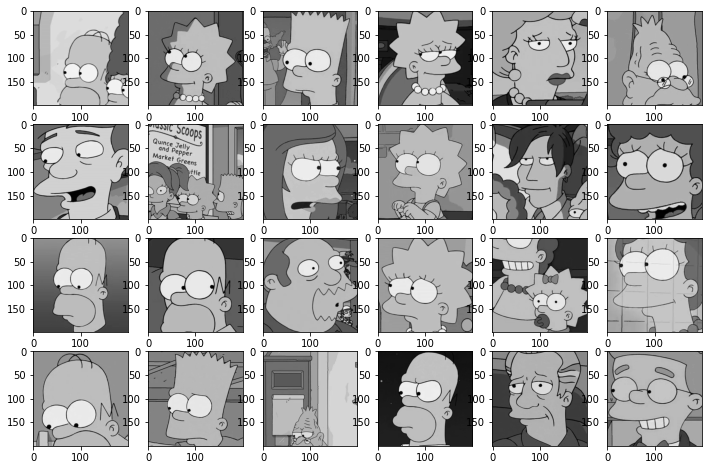

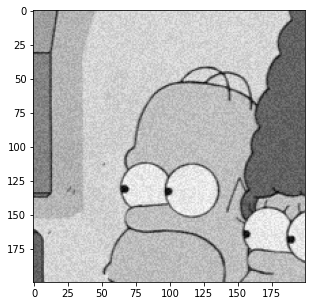

In [39]:
plt.figure(figsize=(6*2,4*2))
for i in range(Y.shape[1]):
    plt.subplot(4,6,i+1)
    plt.imshow(Y.squeeze(0)[i].reshape(200,200), cmap='gray')
    
plt.figure(figsize=(5,5))
plt.imshow(R.squeeze(0).squeeze(0).reshape(200,200), cmap='gray')

In [40]:
Z = hopfield((Y, R, Y))

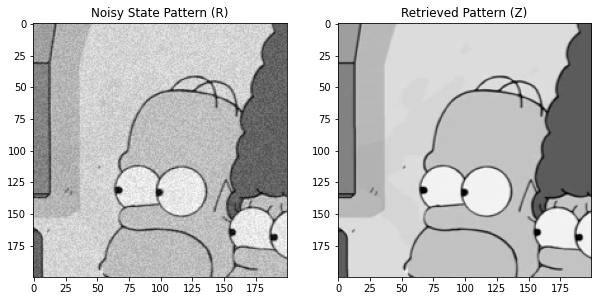

In [41]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Noisy State Pattern (R)')
plt.imshow(R.squeeze(0).squeeze(0).reshape(200,200), cmap='gray')
plt.subplot(1,2,2)
plt.title('Retrieved Pattern (Z)')
plt.imshow(Z.squeeze(0).squeeze(0).reshape(200,200), cmap='gray')

Screenshots from Appendix 1 of the [paper](https://arxiv.org/abs/2008.02217): 

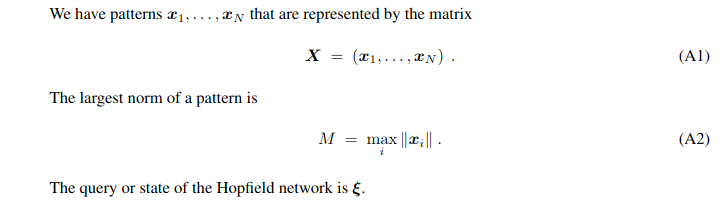

Therefore the energy is:

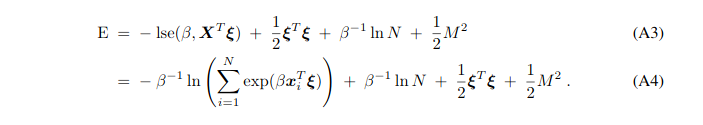

In [12]:
def get_energy(R, Y, beta):
    lse = -(1.0/beta)*torch.logsumexp(beta*(torch.bmm(R, Y.transpose(1,2))), dim=2) # -lse(beta, Y^T*R)
    lnN = (1.0/beta)*torch.log(torch.tensor(Y.shape[1], dtype=float)) # beta^-1*ln(N)
    RTR = torch.bmm(R, R.transpose(1,2)) # R^T*R
    M = 0.5*((torch.max(torch.linalg.norm(Y, dim=2), dim=1))[0]**2.0) # 0.5*M^2  *very large value*
    energy = lse + lnN + RTR + M
    return energy

Energy of noise pattern: 

In [174]:
get_energy(R, Y, hopfield.scaling)

torch.Size([1, 1]) torch.Size([1]) torch.Size([1, 1, 1]) torch.Size([1])


tensor([[[154.4583]]], dtype=torch.float64)

Energy of retrieved pattern (lower as expected):

In [175]:
get_energy(Z, Y, hopfield.scaling)

torch.Size([1, 1]) torch.Size([1]) torch.Size([1, 1, 1]) torch.Size([1])


tensor([[[3.7474]]], dtype=torch.float64)